# Introduction 

In this lecture I demonstrate the power of the type system of Julia using types that represent playing cards, decks of cards, and poker hands.

If you don’t play poker, you can read about it at http://en.wikipedia.org/wiki/Poker, but you don’t have to; I’ll tell you what you need to know for the exercises.

# Card objects

There are fifty-two cards in a deck, each of which belongs to one of four suits and one of thirteen ranks. The suits are Spades, Hearts, Diamonds, and Clubs. The ranks are Ace, 2, 3, 4, 5, 6, 7, 8, 9, 10, Jack, Queen, and King. Depending on the game that you are playing, an Ace may be higher than King or lower than 2.

If we want to define a new object to represent a playing card, it is obvious what the attributes should be: rank and suit. It is not as obvious what type the attributes should be. One possibility is to use strings containing words like `"Spade"` for suits and `"Queen"` for ranks. One problem with this implementation is that it would not be easy to compare cards to see which had a higher rank or suit.

An alternative is to use integers to encode the ranks and suits. In this context, “encode” means that we are going to define a mapping between numbers and suits, or between numbers and ranks. This kind of encoding is not meant to be a secret (that would be “encryption”).

For example, this table shows the suits and the corresponding integer codes:

- Spades  ↦  4
- Hearts  ↦  3
- Diamonds  ↦  2
- Clubs  ↦  1

This code makes it easy to compare cards; because higher suits map to higher numbers, we can compare suits by comparing their codes.

I am using the ↦ symbol to make it clear that these mappings are not part of the Julia program. They are part of the program design, but they don’t appear explicitly in the code.

The struct definition for `Card` looks like this:

In [1]:
struct Card
    suit :: Int
    rank :: Int
    function Card(suit::Int, rank::Int)
        @assert(1 ≤ suit ≤ 4, "suit is between 1 and 4")
        @assert(1 ≤ rank ≤ 13, "rank is between 1 and 13")
        new(suit, rank)
    end
end

To create a `Card`, you call `Card` with the suit and rank of the card you want.

In [2]:
queen_of_diamonds = Card(2, 12)

Card(2, 12)

# Constants

In order to print `Card` objects in a way that people can easily read, we need a mapping from the integer codes to the corresponding ranks and suits. A natural way to do that is with arrays of strings:

In [4]:
const suit_names = ["Clubs", "Diamonds", "Hearts", "Spades"]
const rank_names = ["Ace", "2", "3", "4", "5", "6", "7", 
              "8", "9", "10", "Jack", "Queen", "King"];

Variables like `suit_names` and `rank_names`, which are defined outside of a type definition and of any method, are called `global` variables. The keyword `const` solves the performance problem of global variables.

Now we can an appropriate `show` method:

In [5]:
function Base.show(io::IO, card::Card)
    print(io, rank_names[card.rank], " of ", suit_names[card.suit])
end

With the methods we have so far, we can create and print cards:

In [6]:
card1 = Card(2, 11)

Jack of Diamonds

# Comparing cards

For built-in types, there are relational operators (`<`, `>`, `==`, etc.) that compare values and determine when one is greater than, less than, or equal to another. For programmer-defined types, we can override the behavior of the built-in operators by providing a method named: `Base.isless`.

The correct ordering for cards is not obvious. For example, which is better, the 3 of Clubs or the 2 of Diamonds? One has a higher rank, but the other has a higher suit. In order to compare cards, you have to decide whether rank or suit is more important.

The answer might depend on what game you are playing, but to keep things simple, we’ll make the arbitrary choice that suit is more important, so all of the Spades outrank all of the Diamonds, and so on.

With that decided, we can write `Base.isless`:

In [7]:
function Base.isless(c1::Card, c2::Card)
    isless((c1.suit, c1.rank), (c2.suit, c2.rank))
end

# Unit testing

*Unit testing* is a way to see if your code is correct by checking that the results are what you expect. It can be helpful to ensure your code still works after you make changes, and can be used when developing as a way of specifying the behaviors your code should have when complete.

Simple unit testing can be performed with the `@test()` macros:

In [15]:
using Base.Test

@test Card(1,4) < Card(2,4)
@test Card(3,12) ≤ Card(3,13)
@test Card(3,12) > Card(3,11)
@test Card(3, 4) ≥ Card(3,4)

Test Passed

Tests that the expression after `@test` evaluates to `true`. Returns a `"Test Passed"` if it does, a `"Test Failed"` if it is `false`, and an `"Error Result"` if it could not be evaluated.

# Decks

Now that we have Cards, the next step is to define Decks. Since a deck is made up of cards, it is natural for each Deck to contain an array of cards as an attribute.

The following is a class definition for `Deck`. The constructor creates the attribute cards and generates the standard set of fifty-two cards:

In [16]:
struct Deck
    cards :: Array{Card, 1}
    function Deck()
        deck = new(Card[])
        for suit in 1:4
            for rank in 1:13
                push!(deck.cards, Card(suit, rank))
            end
        end
        deck
    end
end

The easiest way to populate the deck is with a nested loop. The outer loop enumerates the suits from 1 to 4. The inner loop enumerates the ranks from 1 to 13. Each iteration creates a new `Card` with the current suit and rank, and pushes it to `deck.cards`.

Here is a `Base.show` method for `Deck`:

In [17]:
function Base.show(io::IO, deck::Deck)
    for card in deck.cards
        println(io, card)
    end
end

Here’s what the result looks like:

In [30]:
deck = Deck()
println(deck)

Ace of Clubs
2 of Clubs
3 of Clubs
4 of Clubs
5 of Clubs
6 of Clubs
7 of Clubs
8 of Clubs
9 of Clubs
10 of Clubs
Jack of Clubs
Queen of Clubs
King of Clubs
Ace of Diamonds
2 of Diamonds
3 of Diamonds
4 of Diamonds
5 of Diamonds
6 of Diamonds
7 of Diamonds
8 of Diamonds
9 of Diamonds
10 of Diamonds
Jack of Diamonds
Queen of Diamonds
King of Diamonds
Ace of Hearts
2 of Hearts
3 of Hearts
4 of Hearts
5 of Hearts
6 of Hearts
7 of Hearts
8 of Hearts
9 of Hearts
10 of Hearts
Jack of Hearts
Queen of Hearts
King of Hearts
Ace of Spades
2 of Spades
3 of Spades
4 of Spades
5 of Spades
6 of Spades
7 of Spades
8 of Spades
9 of Spades
10 of Spades
Jack of Spades
Queen of Spades
King of Spades



# Add, remove, shuffle and sort

To deal cards, we would like a method that removes a card from the deck and returns it. The array method `pop!` provides a convenient way to do that:

In [19]:
function pop_card!(deck::Deck)
   pop!(deck.cards) 
end

pop_card! (generic function with 1 method)

Since `pop!` removes the last card in the array, we are dealing from the bottom of the deck.

To add a card, we can use the array method `push!`:

In [32]:
function add_card!(deck::Deck, card::Card)
    push!(deck.cards, card)
    nothing
end

add_card! (generic function with 1 method)

A method like this that uses another method without doing much work is sometimes called a veneer. The metaphor comes from woodworking, where a veneer is a thin layer of good quality wood glued to the surface of a cheaper piece of wood to improve the appearance.

In this case `add_card!` is a “thin” method that expresses a list operation in terms appropriate for decks. It improves the appearance, or interface, of the implementation.

As another example, we can write a method named `shuffle_deck!` using the function `shuffle!`:

In [34]:
function shuffle_deck!(deck::Deck)
    shuffle!(deck.cards)
    nothing
end

shuffle_deck! (generic function with 1 method)

Write a method named `sort_deck!` that uses the function `sort!` to sort the cards in a `Deck`. `sort!` uses the `Base.isless` method we defined to determine the order.

In [35]:
function sort_deck!(deck::Deck)
    sort!(deck.cards)
    nothing
end

sort_deck! (generic function with 1 method)

We can now check these functions:

In [38]:
deck = Deck()
card = pop_card!(deck)
println(card)

King of Spades


In [39]:
shuffle_deck!(deck)
println(deck)

7 of Clubs
King of Clubs
7 of Hearts
5 of Spades
4 of Clubs
2 of Diamonds
3 of Clubs
Ace of Diamonds
Jack of Clubs
Ace of Hearts
2 of Clubs
10 of Diamonds
8 of Hearts
10 of Clubs
Ace of Clubs
King of Diamonds
3 of Diamonds
6 of Diamonds
Queen of Spades
8 of Spades
4 of Diamonds
Jack of Spades
8 of Diamonds
3 of Spades
2 of Hearts
5 of Diamonds
Queen of Hearts
5 of Hearts
6 of Clubs
4 of Hearts
8 of Clubs
6 of Spades
4 of Spades
3 of Hearts
9 of Hearts
7 of Diamonds
9 of Diamonds
9 of Spades
5 of Clubs
Queen of Clubs
6 of Hearts
Jack of Hearts
9 of Clubs
King of Hearts
2 of Spades
Jack of Diamonds
10 of Spades
7 of Spades
10 of Hearts
Ace of Spades
Queen of Diamonds



In [40]:
add_card!(deck, card)
sort_deck!(deck)
println(deck)

Ace of Clubs
2 of Clubs
3 of Clubs
4 of Clubs
5 of Clubs
6 of Clubs
7 of Clubs
8 of Clubs
9 of Clubs
10 of Clubs
Jack of Clubs
Queen of Clubs
King of Clubs
Ace of Diamonds
2 of Diamonds
3 of Diamonds
4 of Diamonds
5 of Diamonds
6 of Diamonds
7 of Diamonds
8 of Diamonds
9 of Diamonds
10 of Diamonds
Jack of Diamonds
Queen of Diamonds
King of Diamonds
Ace of Hearts
2 of Hearts
3 of Hearts
4 of Hearts
5 of Hearts
6 of Hearts
7 of Hearts
8 of Hearts
9 of Hearts
10 of Hearts
Jack of Hearts
Queen of Hearts
King of Hearts
Ace of Spades
2 of Spades
3 of Spades
4 of Spades
5 of Spades
6 of Spades
7 of Spades
8 of Spades
9 of Spades
10 of Spades
Jack of Spades
Queen of Spades
King of Spades



# Abstract types

We want a class to represent a “hand”, that is, the cards held by one player. A hand is similar to a deck: both are made up of a collection of cards, and both require operations like adding and removing cards.

A hand is also different from a deck; there are operations we want for hands that don’t make sense for a deck. For example, in poker we might compare two hands to see which one wins. In bridge, we might compute a score for a hand in order to make a bid.

So we need a way to group related *concrete types*. In Julia this is done by defining an *abstract type* that serves as a parent in a type graph for both `Deck` and `Hand`.

Let's call this abstract type `CardSet`:

In [1]:
abstract type CardSet <: Any end

The `abstract type` keyword introduces a new abstract type. The name can be optionally followed by `<:` and an already-existing abstract type, indicating that the newly declared abstract type is a subtype of this "parent" type.

When no supertype is given, the default supertype is `Any` – a predefined abstract type that all objects are instances of and all types are subtypes of.

We can now express that `Deck` is a descendant of `CardSet`. First we have now to restart the kernel and run the following code:

In [2]:
struct Card
    suit :: Int
    rank :: Int
    function Card(suit::Int, rank::Int)
        @assert(1 ≤ suit ≤ 4, "suit is between 1 and 4")
        @assert(1 ≤ rank ≤ 13, "rank is between 1 and 13")
        new(suit, rank)
    end
end

const suit_names = ["Clubs", "Diamonds", "Hearts", "Spades"]
const rank_names = ["Ace", "2", "3", "4", "5", "6", "7", 
              "8", "9", "10", "Jack", "Queen", "King"];

function Base.show(io::IO, card::Card)
    print(io, rank_names[card.rank], " of ", suit_names[card.suit])
end

function Base.isless(c1::Card, c2::Card)
    isless((c1.suit, c1.rank), (c2.suit, c2.rank))
end

After the name of the struct we put `<:` and the name of the abstract type that is the "parent":

In [3]:
struct Deck <: CardSet
    cards :: Array{Card, 1}
    function Deck()
        deck = new(Card[])
        for suit in 1:4
            for rank in 1:13
                push!(deck.cards, Card(suit, rank))
            end
        end
        deck
    end
end

The operator `isa` checks whether an object is of a given type:

In [4]:
deck = Deck()
deck isa CardSet

true

A hand is also a kind of `CardSet`:

In [5]:
struct Hand <: CardSet
    cards :: Array{Card, 1}
    label :: String
    function Hand(label::String="")
        new(Card[], label)
    end
end

Instead of populating the hand with 52 new cards, the constructor for `Hand` initializes `cards` with an empty array. An optional argument can be passed to the constructor giving a `label` to the `Hand`.

In [6]:
hand = Hand("new hand")
hand.cards

0-element Array{Card,1}

# Methods

We can now express the common operations between `Deck` and `Hand` as methods having as argument `CardSet`:

In [22]:
function Base.show(io::IO, cs::CardSet)
    for card in cs.cards
        println(io, card)
    end
end

function pop_card!(cs::CardSet)
   pop!(cs.cards) 
end

function add_card!(cs::CardSet, card::Card)
    push!(cs.cards, card)
    nothing
end

add_card! (generic function with 1 method)

Shuffle is only applicable to `Deck`:

In [19]:
function shuffle_deck!(deck::Deck)
    shuffle!(deck.cards)
    nothing
end

show (generic function with 2 methods)

Sort is only useful for `Hand`:

In [20]:
function sort_hand!(hand::Hand)
    sort!(hand.cards)
    nothing
end

show (generic function with 3 methods)

We can use `pop_card` and `add_card` to deal a card:

In [23]:
deck = Deck()
shuffle_deck!(deck)
card = pop_card!(deck)
add_card!(hand, card)
println(hand)

10 of Hearts
6 of Clubs
2 of Hearts
7 of Hearts



A natural next step is to encapsulate this code in a method called `move_cards!`:

In [24]:
function move_cards!(cs1::CardSet, cs2::CardSet, n::Int)
    @assert 1 ≤ n ≤ length(cs1.cards)
    for i in 1:n
        card = pop_card!(cs1)
        add_card!(cs2, card)
    end
    nothing
end

move_card! (generic function with 1 method)

`deal_cards!` takes three arguments, two `CardSet` objects and the number of cards to deal. It modifies both `CardSet` objects, and returns `nothing`.

In some games, cards are moved from one hand to another, or from a hand back to the deck. You can use `move_cards!` for any of these operations: `cs1` and `cs2` can be either a `Deck` or a `Hand`.

# Type diagrams

So far we have seen stack diagrams, which show the state of a program, and object diagrams, which show the attributes of an object and their values. These diagrams represent a snapshot in the execution of a program, so they change as the program runs.

They are also highly detailed; for some purposes, too detailed. A *type diagram* is a more abstract representation of the structure of a program. Instead of showing individual objects, it shows types and the relationships between them.

There are several kinds of relationship between types:

- Objects of a concrete type might contain references to objects of another type. For example, each `Rectangle` contains a reference to a `Point`, and each `Deck` contains references to an array of `Card`s. This kind of relationship is called *HAS-A*, as in, “a `Rectangle` has a `Point`.

- One type might inherit from an abstract type. This relationship is called *IS-A*, as in, “a `Hand` is a kind of a `CardSet`.”

- One type might depend on another in the sense that objects of one type take objects of the second type as parameters, or use objects of the second type as part of a computation. This kind of relationship is called a *dependency*.

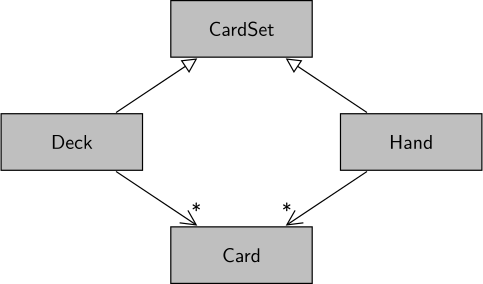

In [70]:
using TikzPictures
TikzPicture(L"""
    \node(cs) [draw, fill=lightgray, minimum width=2.5cm, minimum height=1cm]{CardSet};
    \node(de) [draw, fill=lightgray, minimum width=2.5cm, minimum height=1cm] at(-3, -2) {Deck};
    \node(ha) [draw, fill=lightgray, minimum width=2.5cm, minimum height=1cm] at(3, -2) {Hand};
    \node(ca) [draw, fill=lightgray, minimum width=2.5cm, minimum height=1cm] at(0, -4) {Card};
    \draw[arrows = {-Triangle[line width=1.2pt, open, length=15pt, width=15pt]}] (de)--(cs);
    \draw[arrows = {-Triangle[line width=1.2pt, open, length=15pt, width=15pt]}] (ha)--(cs);
    \draw[arrows = {-Straight Barb[line width=1.2pt, length=15pt, width=15pt]}] (de)--(ca);
    \draw[arrows = {-Straight Barb[line width=1.2pt, length=15pt, width=15pt]}] (ha)--(ca);
    \node at(-0.8, -3.2){*};
    \node at(0.8, -3.2){*};
"""; options="very thick, scale=2, transform shape", preamble="""
    \\usepackage{newtxmath}
    \\renewcommand{\\familydefault}{\\sfdefault}
    \\usepackage{cancel}
    \\usetikzlibrary{arrows.meta}
""")

The arrow with a hollow triangle head represents an IS-A relationship; in this case it indicates that `Hand` inherits from `CardSet`.

The standard arrow head represents a HAS-A relationship; in this case a `Deck` has references to `Card` objects.

The star (`*`) near the arrow head is a multiplicity; it indicates how many `Card`s a `Deck` has. A multiplicity can be a simple number, like `52`, a range, `like 5:7` or a star, which indicates that a `Deck` can have any number of `Card`s.

There are no dependencies in this diagram. They would normally be shown with a dashed arrow. Or if there are a lot of dependencies, they are sometimes omitted

# Debugging

To know of an object has a IS-A relationship with a certain type, we can use the operator `isa`:

In [28]:
hand isa CardSet

true

But `hand` is not of type `CardSet`:

In [26]:
typeof(hand)

Hand

`typeof` returns always the concrete type of the object. 

We can also test whether a type is an descendant of another type with the operator `<:`:

In [29]:
Hand <: CardSet

true